## POS tagging using modified Viterbi

### Data Preparation

In [1]:
import nltk
nltk.download('universal_tagset')
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# reading the Treebank tagged sentences
import nltk
nltk.download('treebank')
nltk_treebank_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [3]:
nltk_treebank_data[:1]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')]]

In [4]:
# Splitting into train and validation
random.seed(1234)
train_set, validation_set = train_test_split(nltk_treebank_data,test_size=0.05)

print(len(train_set))
print(len(validation_set))
print(train_set[-1])

3718
196
[('The', 'DET'), ('new', 'ADJ'), ('securities', 'NOUN'), (',', '.'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('federal', 'ADJ'), ('government', 'NOUN'), ("'s", 'PRT'), ('regular', 'ADJ'), ('quarterly', 'ADJ'), ('refunding', 'VERB'), (',', '.'), ('will', 'VERB'), ('consist', 'VERB'), ('of', 'ADP'), (':', '.')]


In [5]:
# Getting list of tagged words
train_words_list = [tup for sent in train_set for tup in sent]
len(train_words_list)

95657

In [6]:
# tokens 
train_tokens_list = [pair[0] for pair in train_words_list]
train_tokens_list[:10]

['Still',
 ',',
 'some',
 'market',
 'analysts',
 'say',
 '0',
 'the',
 'current',
 '3.3']

In [7]:
# vocabulary
unique_train_words_list = set(train_tokens_list)
print(len(unique_train_words_list))

12065


In [8]:
# number of tags
unique_train_tags_list = set([i[1] for i in train_words_list])
print(len(unique_train_tags_list))
print(unique_train_tags_list)

12
{'PRT', 'NUM', 'ADJ', 'PRON', 'CONJ', 'ADP', 'ADV', 'NOUN', '.', 'VERB', 'X', 'DET'}


### 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

#### Emission Probabilities

In [9]:
# computing P(w/t) and storing in T x V matrix
train_tags_len_list = len(unique_train_tags_list)
train_words_len_list = len(unique_train_words_list)
word_given_tag = np.zeros((train_tags_len_list, train_words_len_list))
print(word_given_tag.shape)

(12, 12065)


In [0]:
# compute word given tag: Emission Probability
def word_given_tag_func(word, tag, train_bag = train_words_list):
#     (tony,NNP)
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [0]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def tag2_given_tag1(t2, t1, train_bag = train_words_list):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [0]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(unique_train_tags_list), len(unique_train_tags_list)), dtype='float32')

for i, t1 in enumerate(list(unique_train_tags_list)):
    for j, t2 in enumerate(list(unique_train_tags_list)): 
        tags_matrix[i, j] = tag2_given_tag1(t2, t1)[0]/tag2_given_tag1(t2, t1)[1]

In [0]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(unique_train_tags_list), index=list(unique_train_tags_list))

In [14]:
tags_df.head()

,PRT,NUM,ADJ,PRON,CONJ,ADP,ADV,NOUN,.,VERB,X,DET
PRT,0.001635,0.056900,0.084696,0.017986,0.002289,0.020929,0.009810,0.247874,0.042511,0.401897,0.014061,0.099411
NUM,0.025831,0.183492,0.035036,0.001485,0.012767,0.035036,0.002969,0.357185,0.115202,0.017518,0.209917,0.003563
ADJ,0.010401,0.021298,0.066204,0.000660,0.016510,0.077596,0.004788,0.700016,0.064058,0.012217,0.021298,0.004953
PRON,0.012261,0.007663,0.071264,0.008046,0.005364,0.022989,0.033333,0.209962,0.041762,0.486207,0.091571,0.009579
CONJ,0.005143,0.042543,0.114540,0.059374,0.000468,0.054698,0.053763,0.349229,0.035998,0.155680,0.008883,0.119682


### 3. Vanilla Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [15]:
len(train_words_list)

95657

In [16]:
train_words_list[:5]

[('Still', 'ADV'),
 (',', '.'),
 ('some', 'DET'),
 ('market', 'NOUN'),
 ('analysts', 'NOUN')]

In [0]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_words_list):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag_func(words[key], tag)[0]/word_given_tag_func(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [0]:
## 4. Evaluating on validation Set

In [0]:
random.seed(1234)

# list of tagged words
validation_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words
validation_words = [tup[0] for sent in validation_set for tup in sent]

# tagging the Validation sentences

tagged_seq = Vanilla_Viterbi(validation_words)

In [20]:

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification with Method 1 is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm after modification with Method 1 is - 0.9033672046224347


##### Before proceeding for dealing with unknown words, lets first see how many unknown words we have. Unknows words would be those words that are present in the test set but not in the train set. That is the words the algorithm has not seen before.

In [21]:
# Unknown words 

unknown_words_in_validation = set([t for t in validation_words])

unknown_words = list(unknown_words_in_validation - unique_train_words_list)
print("Total Unknown words :", len(unknown_words))


Total Unknown words : 343


### Solve the problem of unknown words

### Method 1

If word in unknown then
    consider only the transition_p (emission probability being 0)
else 
    consider both the emission and transition probability.

In [0]:
def Vanilla_Viterbi_Method_1(words, train_bag = train_words_list):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag_func(words[key], tag)[0]/word_given_tag_func(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            if word not in unique_train_words_list:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# tagging the test sentences with Method 1 
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_Method_1 (validation_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, validation_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.935445307830245


### Method : 2

In [0]:
def Unigram_Tagger_backedup_by_rulebased(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]
    
    regex_based_tagger = nltk.RegexpTagger(patterns)
    lexicon_tagger = nltk.UnigramTagger(train_set, backoff=regex_based_tagger)
    return lexicon_tagger.tag_sents([[(word)]])
    

In [0]:
def Vanilla_Viterbi_Method_2 (words, train_bag = train_words_list):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the Unigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in unique_train_words_list:
            unknown_word_tag = Unigram_Tagger_backedup_by_rulebased(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag_func(words[key], tag)[0]/word_given_tag_func(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [28]:
# tagging the test sentences
viterbi_unigram_tagged_seq = Vanilla_Viterbi_Method_2(validation_words)

# accuracy
viterbi_unigram_word_check = [i for i, j in zip(viterbi_unigram_tagged_seq, validation_run_base) if i == j]

viterbi_unigram_accuracy = len(viterbi_unigram_word_check)/len(viterbi_unigram_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_unknown_words_method_2 i.e. Unigram_Tagger_backedup_by_rulebased is -", viterbi_unigram_accuracy)

The accuracy of the Vanilla_Viterbi_for_unknown_words_method_2 i.e. Unigram_Tagger_backedup_by_rulebased is - 0.9583582386929668


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [29]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Unigram Tagger', viterbi_unigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.336720
Optimized Vanilla Viterbi,93.544531
Viterbi + Unigram Tagger,95.835824


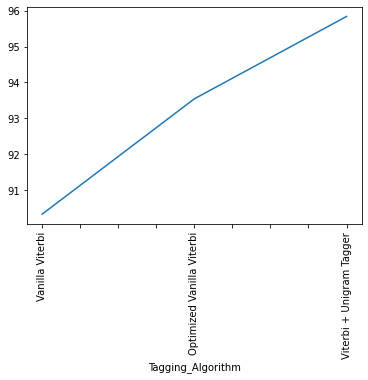

In [30]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

In [0]:
#### Testing on Sample

In [0]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [33]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [0]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]

# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [0]:
sample_test_tagged_words[:2]

In [35]:
# 1. Vanilla Viterbi
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7569060773480663


In [36]:
# 2. Vanilla Viterbi Method 2
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_Method_1(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_method1_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_unknown_words_method_1 on the sample test data is -", sample_test_viterbi_method1_accuracy)


The accuracy of the Vanilla_Viterbi_for_unknown_words_method_1 on the sample test data is - 0.856353591160221


In [37]:
#3. Vanilla Viterbi Method 2
# tagging the test sentences
sample_test_viterbi_unigram_tagged_seq = Vanilla_Viterbi_Method_2(sample_test_tagged_words)

# accuracy
sample_test_viterbi_unigram_check = [i for i, j in zip(sample_test_viterbi_unigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_method2_accuracy = len(sample_test_viterbi_unigram_check)/len(sample_test_viterbi_unigram_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_unknown_words_method_2 on the sample test data is -", sample_test_viterbi_method2_accuracy)


The accuracy of the Vanilla_Viterbi_for_unknown_words_method_2 on the sample test data is - 0.9281767955801105


In [0]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Vanilla Viterbi + Transition Prob.' , sample_test_viterbi_method1_accuracy*100], 
                  ['Vanilla Viterbi + Unigram_backedup_by_rulebased', sample_test_viterbi_method2_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

In [39]:
sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Vanilla Viterbi + Transition Prob.,85.635359
Vanilla Viterbi + Unigram_backedup_by_rulebased,92.817680


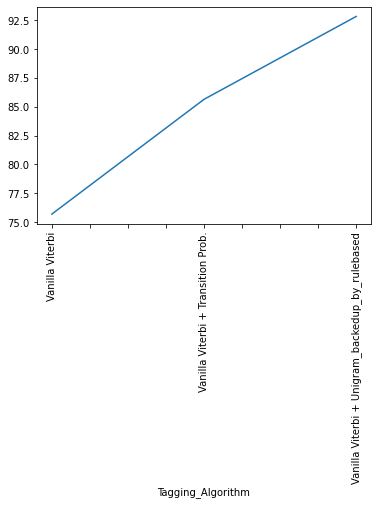

In [40]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [41]:
test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_1)
pos_tagged_sequence_with_viterbi_method2 = Vanilla_Viterbi_Method_2(words_test_sentence_1)

# Creating dataframe for comparison
cols = ['vanilla_viterbi_tags', 'viterbi_method2_tags_with_corrections']
tags_correction = pd.DataFrame(columns = cols)
tags_correction = tags_correction.fillna(0)

tags_correction.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction.viterbi_method2_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_method2]

tags_correction

,vanilla_viterbi_tags,viterbi_method2_tags_with_corrections
0,"(Android, PRT)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, PRT)","(Google, NOUN)"
9,"(., .)","(., .)"
